**Install Required Libraries**

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

**Loading image**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Function to load an image from a given path
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    transform = transforms.ToTensor()
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Paths to images
image_path1 = '/content/drive/MyDrive/AIP Assignment 1/Avinash Barak/Question 1/img1.png'  # first image path
image_path2 = '/content/drive/MyDrive/AIP Assignment 1/Avinash Barak/Question 1/img2.png'  # Second image path

# Load images
image_tensor1 = load_image(image_path1)
image_tensor2 = load_image(image_path2)

**Generating Scale Space**

In [4]:
import torch.nn.functional as F

def generate_scale_space(image_tensor, num_scales):
    scale_space = []
    for i in range(num_scales):
        sigma = 2 ** i  # increase blur
        blurred = F.gaussian_blur(image_tensor, kernel_size=(5, 5), sigma=(sigma, sigma))
        scale_space.append(blurred)
    return scale_space

**Defining functions**

In [5]:
import numpy as np

def gaussian_kernel(size, sigma):
    """Creates a 2D Gaussian kernel."""
    x, y = torch.meshgrid(torch.arange(size), torch.arange(size))
    x, y = x - size // 2, y - size // 2
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

def gaussian_blur(image, kernel_size, sigma):
    """Applies Gaussian blur to an image using a given kernel size and sigma."""
    kernel = gaussian_kernel(kernel_size, sigma).to(image.device)
    padding = kernel_size // 2
    return F.conv2d(image, kernel, padding=padding)

def generate_scale_space(image_tensor, num_scales):
    scale_space = []
    for i in range(num_scales):
        sigma = 2 ** i  # increase blur
        blurred = gaussian_blur(image_tensor, kernel_size=5, sigma=sigma)
        scale_space.append(blurred)
    return scale_space


In [6]:
def find_extrema(scale_space, contrast_threshold=0.04):
    keypoints = []
    for s in range(1, len(scale_space) - 1):
        current = scale_space[s][0, 0]  # Accessing the first channel of the current scale
        previous = scale_space[s - 1][0, 0]
        next_scale = scale_space[s + 1][0, 0]

        for y in range(1, current.shape[0] - 1):
            for x in range(1, current.shape[1] - 1):
                pixel = current[y, x]
                # Define the 3x3x3 neighborhood
                neighborhood = torch.stack([previous[y - 1:y + 2, x - 1:x + 2],
                                            current[y - 1:y + 2, x - 1:x + 2],
                                            next_scale[y - 1:y + 2, x - 1:x + 2]])

                # Check if pixel is a local extremum
                if (pixel == torch.max(neighborhood) or pixel == torch.min(neighborhood)):
                    keypoints.append((y, x, s))  # Store the coordinates and scale

    return keypoints

**Applying functions**

In [ ]:
scale_space1 = generate_scale_space(image_tensor1, num_scales=5)
scale_space2 = generate_scale_space(image_tensor2, num_scales=5)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
keypoints1 = find_extrema(scale_space1)
keypoints2 = find_extrema(scale_space2)

**Visualizing Keypoints on Images**

In [7]:
# Keypoint plotting
def plot_keypoints(image_tensor, keypoints):
    # Convert tensor back to PIL image
    image_pil = transforms.ToPILImage()(image_tensor.squeeze(0))
    plt.imshow(image_pil, cmap='gray')
    for x, y, _ in keypoints:  #
        plt.scatter(y, x, s=20, color='red', marker='.')
    plt.show()

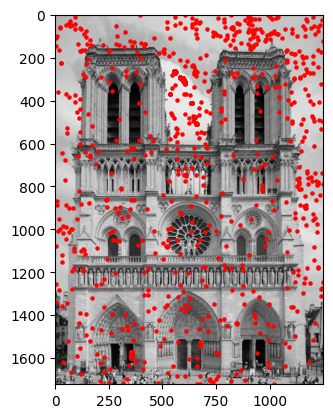

In [ ]:
# Visualize keypoints for the first image
plot_keypoints(image_tensor1, keypoints1)

In [8]:
def plot_keypoints_filtered(image_tensor, keypoints, num_keypoints=100, x_range=(0, 400), y_range=(0, 400)):
    # Convert tensor back to PIL image
    image_pil = transforms.ToPILImage()(image_tensor.squeeze(0))
    plt.imshow(image_pil, cmap='gray')


    keypoints_np = np.array(keypoints)
    filtered_indices = np.where(
        (keypoints_np[:, 1] >= x_range[0]) &
        (keypoints_np[:, 1] <= x_range[1]) &
        (keypoints_np[:, 0] >= y_range[0]) &
        (keypoints_np[:, 0] <= y_range[1])
    )[0]
    filtered_keypoints = [keypoints[i] for i in filtered_indices]


    for i, (y, x, _) in enumerate(filtered_keypoints[:num_keypoints]):
        plt.scatter(x, y, s=20, color='red', marker='.')

    plt.show()


In [ ]:
x_range = (100, 800)
y_range = (100, 600)
plot_keypoints_filtered(image_tensor2, keypoints2, num_keypoints=100, x_range=x_range, y_range=y_range)

**Orientation assignment**

In [ ]:
def compute_gradients(image_tensor):
    # Sobel operators for gradient in X and Y directions
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3)

    # Ensure the image tensor and Sobel operators are on the same device (CPU or GPU)
    image_tensor, sobel_x, sobel_y = image_tensor.to(sobel_x.device), sobel_x.to(image_tensor.device), sobel_y.to(image_tensor.device)

    # Convolve the image with Sobel operators
    grad_x = torch.nn.functional.conv2d(image_tensor, sobel_x, padding=1)
    grad_y = torch.nn.functional.conv2d(image_tensor, sobel_y, padding=1)

    # Compute gradient magnitude and orientation
    magnitude = torch.sqrt(grad_x ** 2 + grad_y ** 2)
    orientation = torch.atan2(grad_y, grad_x) * (180 / np.pi) % 360  # Convert to degrees and normalize

    return magnitude, orientation


In [ ]:
def assign_orientation(keypoints, magnitude, orientation, radius=8):

    oriented_keypoints = []

    for y, x, scale in keypoints:
        # Extract the region around the keypoint
        mag_patch = magnitude[0, 0, max(0, y-radius):y+radius+1, max(0, x-radius):x+radius+1]
        ori_patch = orientation[0, 0, max(0, y-radius):y+radius+1, max(0, x-radius):x+radius+1]

        # Compute histogram of orientations
        histogram = torch.histc(ori_patch, bins=36, min=0, max=360)

        # Find the maximum peak in the histogram
        dominant_orientation = torch.argmax(histogram).item() * 10  # Bin size is 10 degrees

        oriented_keypoints.append((y, x, scale, dominant_orientation))

    return oriented_keypoints


In [ ]:
# Compute gradients of the first image
magnitude, orientation = compute_gradients(image_tensor1)

# Assign orientation to keypoints
oriented_keypoints1 = assign_orientation(keypoints1, magnitude, orientation)

# Now, `oriented_keypoints1` contains keypoints with their assigned orientations

In [ ]:
# Image_tensor2 is second image tensor
magnitude2, orientation2 = compute_gradients(image_tensor2)
# Keypoints2 contains keypoints detected in the second image
oriented_keypoints2 = assign_orientation(keypoints2, magnitude2, orientation2)

**Keypoint descriptor**

In [ ]:
import torch
import numpy as np

def extract_sift_descriptors(keypoints, magnitude, orientation, num_bins=8, patch_size=16, sub_patch_size=4):

    descriptors = []
    bin_width = 360 / num_bins
    half_patch = patch_size // 2

    for y, x, scale, _ in keypoints:
        # Initialize descriptor vector
        descriptor = torch.zeros((sub_patch_size**2, num_bins), dtype=torch.float32)

        # Iterate over each sub-patch
        for dy in range(-half_patch, half_patch, sub_patch_size):
            for dx in range(-half_patch, half_patch, sub_patch_size):
                sub_hist = torch.zeros(num_bins, dtype=torch.float32)

                # Process each pixel within the sub-patch
                for sy in range(dy, dy + sub_patch_size):
                    for sx in range(dx, dx + sub_patch_size):
                        global_y, global_x = int(y + sy), int(x + sx)

                        # Check if the coordinates are within image bounds
                        if 0 <= global_y < magnitude.size(2) and 0 <= global_x < magnitude.size(3):
                            mag = magnitude[0, 0, global_y, global_x]
                            ori = orientation[0, 0, global_y, global_x]

                            # Compute the bin index and accumulate the magnitude
                            bin_idx = int(ori // bin_width) % num_bins
                            sub_hist[bin_idx] += mag

                # Concatenate the histogram of the current sub-patch to the descriptor
                descriptor_idx = (dy + half_patch) // sub_patch_size * sub_patch_size + (dx + half_patch) // sub_patch_size
                descriptor[descriptor_idx, :] = sub_hist

        # Normalize the descriptor to unit length for invariance to illumination changes
        descriptor_flat = descriptor.flatten()
        norm = torch.norm(descriptor_flat)
        if norm > 0:
            descriptor_normalized = descriptor_flat / norm
        else:
            descriptor_normalized = descriptor_flat

        descriptors.append(descriptor_normalized)

    return torch.stack(descriptors)


In [ ]:
descriptors1 = extract_sift_descriptors(oriented_keypoints1, magnitude, orientation)
descriptors2 = extract_sift_descriptors(oriented_keypoints2, magnitude2, orientation2)

**Applying Principal Component Analysis (PCA)**

In [ ]:
pip install scikit-learn
import numpy as np

# Convert PyTorch tensors to NumPy arrays
descriptors1_np = descriptors1.numpy()
descriptors2_np = descriptors2.numpy()

# Combine all descriptors into a single NumPy array for PCA
all_descriptors = np.concatenate([descriptors1_np, descriptors2_np], axis=0)

from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=36)

# Fit PCA on the combined descriptors and transform them to reduced dimensionality
reduced_descriptors = pca.fit_transform(all_descriptors)

num_descriptors1 = descriptors1_np.shape[0]
reduced_descriptors1 = reduced_descriptors[:num_descriptors1]
reduced_descriptors2 = reduced_descriptors[num_descriptors1:]



**Scaling the two images  -shrinking the images by factor of half**

In [9]:
import torch.nn.functional as F

def scale_image_tensor(image_tensor, scale_factor=.5):
    # Get current size
    current_size = image_tensor.size()[2:]  # Skip batch and channel dimensions
    new_size = [int(dim * scale_factor) for dim in current_size]
    # Rescale image tensor
    scaled_image_tensor = F.interpolate(image_tensor, size=new_size, mode='bilinear', align_corners=False)
    return scaled_image_tensor

# Assuming image_tensor1 and image_tensor2 are already loaded using the original load_image function
# Scale the images
scaled_image_tensor1 = scale_image_tensor(image_tensor1, scale_factor=.5)
scaled_image_tensor2 = scale_image_tensor(image_tensor2, scale_factor=.5)

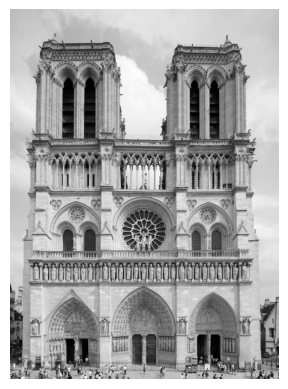

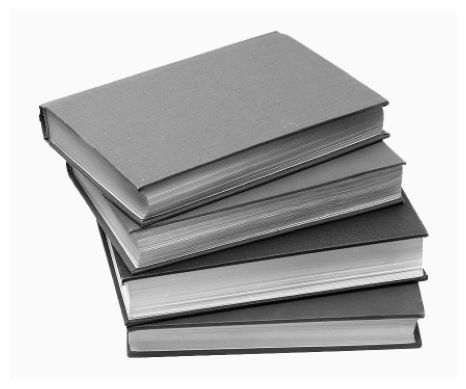

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def show_image_tensor(image_tensor):
    # Remove the batch dimension if present
    if image_tensor.dim() == 4 and image_tensor.shape[0] == 1:
        image_tensor = image_tensor.squeeze(0)
    # Convert the tensor to a PIL image
    image_pil = to_pil_image(image_tensor)
    # Display the image
    plt.imshow(image_pil, cmap='gray')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

show_image_tensor(scaled_image_tensor1)
show_image_tensor(scaled_image_tensor2)


**Dimension of images reduced by half**

In [ ]:
# Assuming image_tensor1 is the original image tensor and scaled_image_tensor1 is the scaled version of the first image
# Print original dimensions
print("Original dimensions:", image_tensor1.shape)
# Print scaled dimensions
print("Scaled dimensions:", scaled_image_tensor1.shape)


Original dimensions: torch.Size([1, 1, 1722, 1250])
Scaled dimensions: torch.Size([1, 1, 861, 625])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


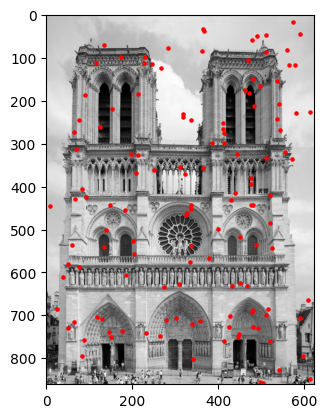

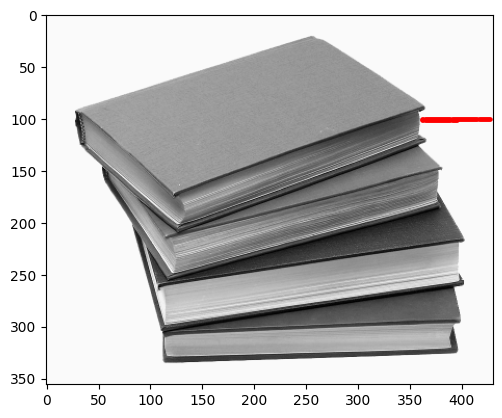

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# For the first scaled image
# Generate scale space and find keypoints
scale_space_scaled1 = generate_scale_space(scaled_image_tensor1, num_scales=5)
keypoints_scaled1 = find_extrema(scale_space_scaled1)

# Visualize keypoints on the first scaled image
plot_keypoints(scaled_image_tensor1, keypoints_scaled1)

# For the second scaled image, using filtered keypoints visualization
# Generate scale space and find keypoints
scale_space_scaled2 = generate_scale_space(scaled_image_tensor2, num_scales=5)
keypoints_scaled2 = find_extrema(scale_space_scaled2)


x_range = (100, 800)
y_range = (100, 600)

plot_keypoints_filtered(scaled_image_tensor2, keypoints_scaled2, num_keypoints=100, x_range=x_range, y_range=y_range)

In [12]:
# Print the number of keypoints detected for each scaled image
num_keypoints_scaled1 = len(keypoints_scaled1)
num_keypoints_scaled2 = len(keypoints_scaled2)

print(f"Number of keypoints detected in scaled image 1: {num_keypoints_scaled1}")
print(f"Number of keypoints detected in scaled image 2: {num_keypoints_scaled2}")

Number of keypoints detected in scaled image 1: 133
Number of keypoints detected in scaled image 2: 117319


**Rotating the two images**

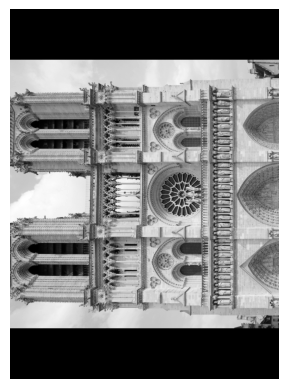

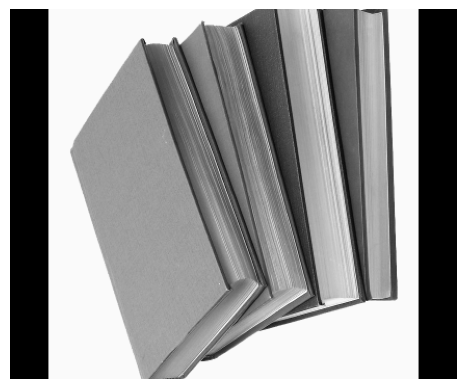

In [13]:
from torchvision.transforms import functional as TF

def rotate_image_tensor(image_tensor, angle):
    # Convert tensor to PIL Image
    image_pil = to_pil_image(image_tensor.squeeze(0))

    # Rotate image
    rotated_image_pil = TF.rotate(image_pil, angle)

    # Convert back to tensor if needed
    rotated_image_tensor = TF.to_tensor(rotated_image_pil).unsqueeze(0)
    return rotated_image_tensor

# Rotate both scaled images by 90 degrees
rotated_scaled_image_tensor1 = rotate_image_tensor(scaled_image_tensor1, 90)
rotated_scaled_image_tensor2 = rotate_image_tensor(scaled_image_tensor2, 90)

# Visualize the rotated images using the show_image_tensor function defined previously
show_image_tensor(rotated_scaled_image_tensor1)
show_image_tensor(rotated_scaled_image_tensor2)

**Finding and visualizing the keypoints for the rotated images**

In [15]:
# Generate scale space for the rotated images
scale_space_rotated1 = generate_scale_space(rotated_scaled_image_tensor1, num_scales=5)
scale_space_rotated2 = generate_scale_space(rotated_scaled_image_tensor2, num_scales=5)

# Find keypoints in the scale spaces of the rotated images
keypoints_rotated1 = find_extrema(scale_space_rotated1)
keypoints_rotated2 = find_extrema(scale_space_rotated2)

In [21]:

# Print the number of keypoints detected for each scaled image
num_keypoints_rotated1 = len(keypoints_rotated1)
num_keypoints_rotated2 = len(keypoints_rotated2)

print(f"Number of keypoints detected in scaled image 1: {num_keypoints_rotated1}")
print(f"Number of keypoints detected in scaled image 2: {num_keypoints_rotated2}")


Number of keypoints detected in scaled image 1: 429975
Number of keypoints detected in scaled image 2: 141497


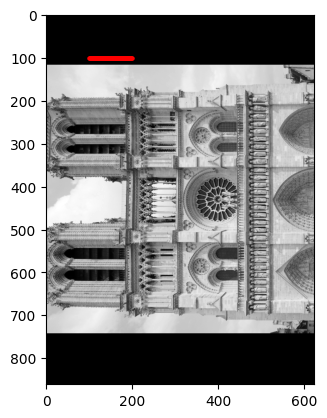

In [22]:
x_range_rotated = (100, 800)
y_range_rotated = (100, 600)
plot_keypoints_filtered(rotated_scaled_image_tensor1, keypoints_rotated1, num_keypoints=100, x_range=x_range_rotated, y_range=y_range_rotated)

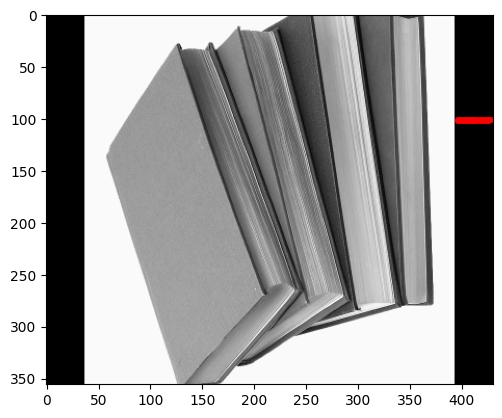

In [16]:
x_range_rotated = (100, 800)
y_range_rotated = (100, 600)
plot_keypoints_filtered(rotated_scaled_image_tensor2, keypoints_rotated2, num_keypoints=100, x_range=x_range_rotated, y_range=y_range_rotated)

**Blurring the images**

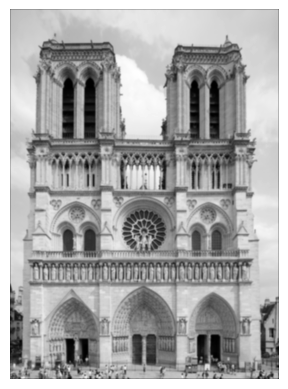

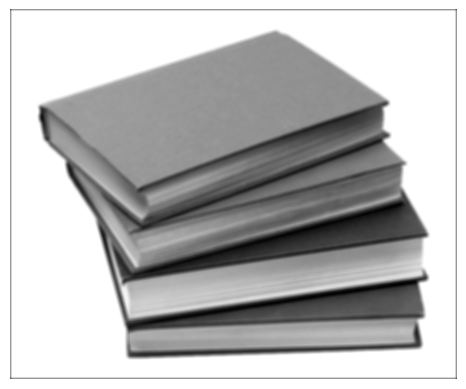

In [25]:
import torch
import numpy as np
import torch.nn.functional as F

def create_gaussian_kernel(kernel_size=5, sigma=2.0):
    """Create a 2D Gaussian kernel."""
    x = np.arange(kernel_size) - kernel_size // 2
    y = np.arange(kernel_size) - kernel_size // 2
    x, y = np.meshgrid(x, y)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    kernel = torch.from_numpy(kernel).float()
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    return kernel

def apply_gaussian_blur(image_tensor, kernel_size=5, sigma=2.0):
    """Applies Gaussian blur to an image tensor using a manually created Gaussian kernel."""
    kernel = create_gaussian_kernel(kernel_size, sigma)
    # Ensure the kernel and the image tensor are on the same device
    kernel = kernel.to(image_tensor.device)
    # Apply convolution with the Gaussian kernel
    # Adjust padding to maintain image size
    padding = kernel_size // 2
    blurred_image_tensor = F.conv2d(image_tensor, kernel, padding=padding)
    return blurred_image_tensor

# Apply a more pronounced Gaussian blur to the original images with a larger kernel and higher sigma
blurred_image_tensor1_more_blurry = apply_gaussian_blur(image_tensor1, kernel_size=9, sigma=4.0)
blurred_image_tensor2_more_blurry = apply_gaussian_blur(image_tensor2, kernel_size=9, sigma=4.0)

# Visualize the more blurry images to verify the effect
show_image_tensor(blurred_image_tensor1_more_blurry)
show_image_tensor(blurred_image_tensor2_more_blurry)

**Finding and visualizing the keypoints**

In [26]:
# Generate scale space for the more blurry images
scale_space_blurry1 = generate_scale_space(blurred_image_tensor1_more_blurry, num_scales=5)
scale_space_blurry2 = generate_scale_space(blurred_image_tensor2_more_blurry, num_scales=5)


In [27]:
# Find keypoints in the scale spaces of the more blurry images
keypoints_blurry1 = find_extrema(scale_space_blurry1)
keypoints_blurry2 = find_extrema(scale_space_blurry2)

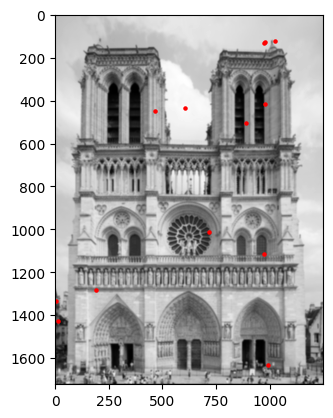

In [28]:
plot_keypoints(blurred_image_tensor1_more_blurry, keypoints_blurry1)

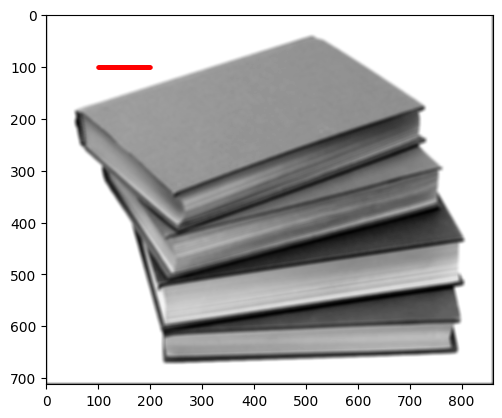

In [29]:

x_range_blurry = (100, 800)
y_range_blurry = (100, 600)

plot_keypoints_filtered(blurred_image_tensor2_more_blurry, keypoints_blurry2, num_keypoints=100, x_range=x_range_blurry, y_range=y_range_blurry)

In [30]:
# Print the number of keypoints detected in each more blurry image
num_keypoints_blurry1 = len(keypoints_blurry1)
num_keypoints_blurry2 = len(keypoints_blurry2)

print("Number of keypoints detected in the first more blurry image:", num_keypoints_blurry1)
print("Number of keypoints detected in the second more blurry image:", num_keypoints_blurry2)

Number of keypoints detected in the first more blurry image: 13
Number of keypoints detected in the second more blurry image: 684071
